# Simplified Camera Pipeline

This notebook is a simplified version of how a camera imaging pipeline works.

In the figure below you can see the steps that are involved in the camera pipeline. We will implement each of these steps in Python.



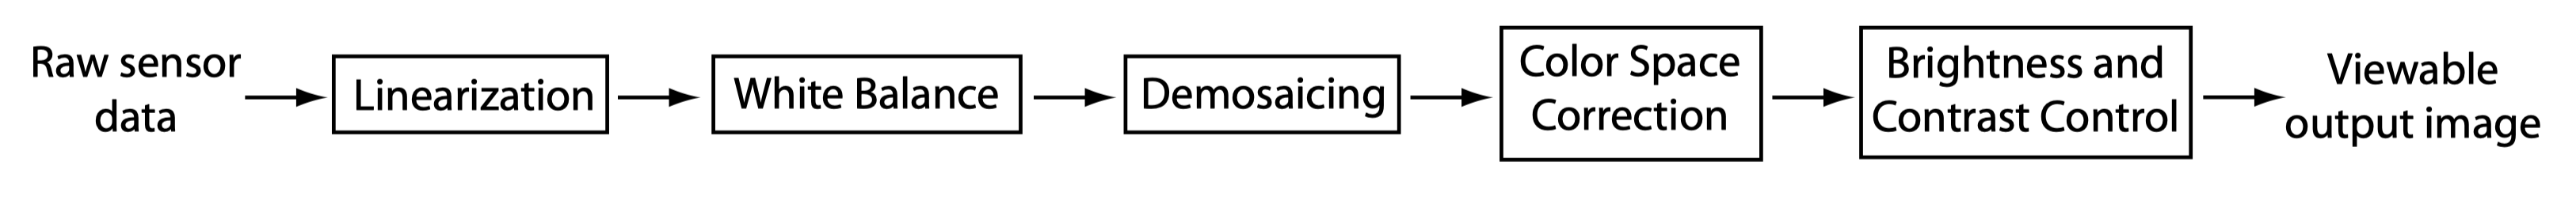


Begin by installing the `rawpy` package that we will use to read the raw image files. The `rawpy` package is based on `LibRaw` library which is based on `dcraw`.

In [ ]:
!pip install rawpy

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import rawpy
import PIL
import numpy as np

Download the raw image file. 

In [ ]:
!curl "http://www.rawsamples.ch/raws/nikon/d3/RAW_NIKON_D3.NEF" -o './RAW_NIKON_D3.NEF' 

The raw image file can be loaded as follows:

In [ ]:
raw_img_data = rawpy.imread('./RAW_NIKON_D3.NEF')
raw_img = raw_img_data.raw_image

Let us look at some metadata from the raw image.

In [ ]:
print(raw_img_data.color_desc)
print(raw_img_data.raw_colors)
print(raw_img_data.raw_colors.shape)

**Question:** What kind of data does the raw image contain based on these metadata?

In [ ]:
# Hint:
print(f"https://en.wikipedia.org/wiki/{raw_img_data.color_desc.decode('utf-8')}")

## Step 1.1: Linearization and dark-current compensation


The data captured by some cameras is not always linear. Mainly, some electronics component in the camera may not have a linear response. The linearization step compensates for these non-linearities with a look-up table, known as opto-electronic conversion function (OECF).

For this particular camera, the data saved in the raw file has already been linearized by the manufacturer.

Even if there is no light, the camera sensor still captures some signal, due to the ambient temperature. The camera pipeline has to compensate for this "dark current" signal. Some cameras, for instance, capture a dark-current image and substract this dark-current image from the image. 

For this particular camera, the data saved in the raw file has already been corrected for dark-current by the manufacturer.


## Step 1.2: Scaling pixels values

We have to convert the pixels values from integer to floating point in range [0, 1].  

To convert the raw image to float we have two choices:

1. **Use min/max normalization.** We find the minimum and maximum values of the raw image values and then normalize the using $img = \frac{img - min}{max - min}$

2. **Use quantile normalization** We find the 0.001 quantile ($q_{min}$) and 0.999 quantile ($q_{max}$) of the raw image and the normalize using $img = \frac{img - q_{max}}{q_{max} - q_{min}}$

**Question**: Which normalization scheme works better and why?

**Answer:** ?

In [ ]:
# min_level = # Extract this from the raw_img
# max_level = # Extract this from the raw_img
print("Min value = ", min_level)
print("Max value = ", max_level)

# min_quantile = # Extract this from the raw_img
# max_quantile = # Extract this from the raw_img
print("Min quantile = ", min_quantile)
print("Max quantile = ", max_quantile)

In [ ]:
# raw_img_linearized_minmax = # apply min/max normalization

# Remember to clip the image to [0, 1] for the quantile normalization
# raw_img_linearized_quantile =  # apply quantile normalization
# raw_img_linearized_quantile =  # clip the values of raw_img_linearized_quantile to [0, 1]

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(raw_img_linearized_minmax, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Min/Max Linearization')
plt.subplot(1, 2, 2)
plt.imshow(raw_img_linearized_quantile, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Quantile Linearization')


raw_img_linearized = raw_img_linearized_quantile

**Question:** Explain the differences between the two linearization methods.

**Answer:** ?

Now let's zoom in to the image and see how the pixels look like.


In [ ]:
plt.imshow(raw_img_linearized[1400:1430, 2100:2130], cmap='gray', vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Quantile Linearization')
print()

The raw image at this stage is in the mosaiced Bayer pattern format which looks like this:

<img src="https://www.researchgate.net/publication/335809150/figure/fig1/AS:962175233433601@1606411860297/Bayer-pattern-CFA-with-size-of-88-Color-figure-online.png"  width="30%" height="80%">

Fore example To access the red color in the image we can do the following

```python
red = mosaic[0::2, 0::2]
```

**Question**: Find the logic to access the other colors:

**Answer**: ?

```python
green_top = #
green_bottom = #
blue = #
``` 

## Step 2: White Balancing 

The red/green/blue sensors in the camera have different sensitivities. The goal of white balancing at this stage is to equalize the contribution of different sensors to the final image.  

Here we perform two different methods for white balancing.

1. **Gray World Algorithm:**

The gray world algorithm uses the the mean values of each color to perform the white balancing. Let $\mu_{red}$, $\mu_{green}$, and $\mu_{blue}$ be the mean values of red, green, and blue pixels in the linearized mosaic image. The `Gray World` algorithm scales each color by a factor so that the new mean values $\mu'_{red}$, $\mu'_{green}$, and $\mu'_{blue}$ are all equal to the $\mu_{green}$.

2. **Using the camera parameters:**
Another alternative is to use the white balancing coefficients provided in the raw image file. You can access the white balancing parameters in the raw files `raw_img_data.camera_whitebalance`. 
 

In [ ]:
# White Balancing Using Gray World Algorithm
def white_balance_gray_world(mosaic):
    red = mosaic[0::2, 0::2]
    # green = # Take the average of green_top and green_bottom
    # blue = # 

    mu_red = np.average(red)
    # mu_green = # calculate the average of the green color
    # mu_blue = # # calculate the average of the blue color

    whitebalance_coefs = [mu_green/mu_red, 1.0, mu_green/mu_blue]
    print("Gray World White Balancing Coefficients: ", whitebalance_coefs)

    whitebalanced_mosaic = np.array(mosaic)
    # whitebalanced_mosaic[0::2, 0::2] *=      # scale red
    # whitebalanced_mosaic[0::2, 1::2] *=      # scale the top green
    # whitebalanced_mosaic[1::2, 0::2] *=      # scale the bottom green
    # whitebalanced_mosaic[1::2, 1::2] *=      # scale blue

    whitebalanced_mosaic = np.clip(whitebalanced_mosaic, 0.0, 1.0)

    return whitebalanced_mosaic


In [ ]:
def white_balance_camera_params(mosaic, camera_whitebalance):
    whitebalance_coefs = np.array(camera_whitebalance)
    # Scale the coeffs by the coefficient of the green channel
    whitebalance_coefs /= whitebalance_coefs[1] 
    print("Camera White Balancing Coefficients: ", whitebalance_coefs[:3])

    whitebalanced_mosaic = np.array(mosaic)
    # whitebalanced_mosaic[0::2, 0::2] *=      # scale red
    # whitebalanced_mosaic[0::2, 1::2] *=      # scale the top green
    # whitebalanced_mosaic[1::2, 0::2] *=      # scale the bottom green
    # whitebalanced_mosaic[1::2, 1::2] *=      # scale blue

    whitebalanced_mosaic = np.clip(whitebalanced_mosaic, 0.0, 1.0)

    return whitebalanced_mosaic


In [ ]:
raw_img_white_balanced_gray_world = white_balance_gray_world(raw_img_linearized)

raw_img_white_balanced_camera = white_balance_camera_params(raw_img_linearized, 
                                                            raw_img_data.daylight_whitebalance)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(raw_img_white_balanced_gray_world, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('White Balanced Using the Gray World Algorithm')

plt.subplot(1, 2, 2)
plt.imshow(raw_img_white_balanced_camera, cmap='gray', vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('White Balanced Using the Camera Coefficients')

print()

**Question:** Explain the differences between the two white balancing methods. Which image has a better white color?

**Answer:** ?

For the rest of the steps we will use the `raw_img_white_balanced_camera`

In [ ]:
raw_img_white_balanced = raw_img_white_balanced_camera

## Step 3: Demosaicing  
The raw image at this stage is in the mosaiced Bayer pattern format. 

The demosiacing step converts the single channel raw image to three full-size R/G/B color channels by interpolating the missing values in the mosaiced Bayer pattern format.

We will implement two different demosaicing algorithms.

1. **Copying each color to its corresponding channel:** This algorithm will reduce the effective output image resolution by a factor of 2.

2. **Using bilinear interpolation to fill the missing color values:** This algorithm does not change the output image size. 

In [ ]:
from scipy.ndimage.filters import convolve

def demosaic_vanilla(mosaic):
    R = mosaic[0::2, 0::2]
    # G =  # Take the average of green_bottom and green_top
    # B =  # 
    # rgb_image = # Stack R, G, B into a 3 channel image

    print("Image size after demosaic_vanilla: ", rgb_image.shape)
    assert rgb_image.shape == (1422, 2144, 3)

    return rgb_image

def demosaic_bilinear(mosaic):
    h, w = mosaic.shape
    channels = {channel: np.zeros((h, w)) for channel in 'RGB'}
    for channel, (y, x) in zip('RGGB', [(0, 0), (0, 1), (1, 0), (1, 1)]):
        channels[channel][y::2, x::2] = mosaic[y::2, x::2]

    R_mosaic, G_mosaic, B_mosaic = tuple(channels[c] for c in 'RGB')

    # convolution kernels
    # green
    H_G = np.asarray(
        [[0.0, 1.0, 0.0],
        [1.0, 4.0, 1.0],
        [0.0, 1.0, 0.0]]) / 4.0
    # red/blue
    H_RB = np.asarray(
        [[1.0, 2.0, 1.0],
        [2.0, 4.0, 2.0],
        [1.0, 2.0, 1.0]]) / 4.0

    # R = # Apply the H_RB filter on R_mosaic
    # G = # Apply the H_G filter on G_mosaic
    # B = # Apply the H_RB filter on B_mosaic
    # rgb_image = # Stack R, G, B into a 3 channel image

    print("Image size after demosaic_bilinear: ", rgb_image.shape)
    assert rgb_image.shape == (2844, 4288, 3)

    return rgb_image

In [ ]:
rgb_img_demosaic_vanilla = demosaic_vanilla(raw_img_white_balanced)

rgb_img_demosaic_bilinear = demosaic_bilinear(raw_img_white_balanced)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img_demosaic_vanilla, vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Vanilla Demosaicing')

plt.subplot(1, 2, 2)
plt.imshow(rgb_img_demosaic_bilinear, vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Bilinear Demosaicing')

print()

For the rest of the steps we will use the `rgb_img_demosaic_bilinear`

In [ ]:
rgb_img_demosaic = rgb_img_demosaic_bilinear

## Step 4: Color Space Conversion 

Now we have to convert the image from camera color space to sRGB color space.

In [ ]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected

In [ ]:
cam2xyz = np.linalg.inv(raw_img_data.rgb_xyz_matrix[0:3, :])
xyz2srgb = np.array([
    [3.2404542, -1.5371385, -0.4985314],
    [-0.9692660,  1.8760108,  0.0415560],
    [0.0556434, -0.2040259,  1.0572252],
])

#  cam2srgb = # Multiply xyz2srgb and cam2xyz to get this matrix
cam2srgb = cam2srgb / cam2srgb.sum(axis=1, keepdims=True)

# srgb_img_demosaic = # Apply the cam2srgb matrix on the output image of the previous step
srgb_img_demosaic = np.clip(srgb_img_demosaic, 0.0, 1.0)


plt.imshow(srgb_img_demosaic, vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Image the in sRGB color space')

## Step 5: Brightness and Contrast Control
As the final step we will apply the Gamma Correction or the the Tone mapping.

1. **Gamma Correction** We simply apply the function $f(x) = x^{1 / \gamma}$ to the pixel values to stretch the darker colors.

2. **S-Shaped Tone Mapping Curve** We apply a S-shaped tone mapping function given by the `tcurve` array.

Run the cell below to see the differences between the two tone mapping curves.

In [ ]:
gamma = 2.2
tone_curve = np.array([0,0.00078,0.0016,0.00242,0.00314,0.00385,0.0046,0.00539,0.00623,0.00712,0.00806,0.00906,0.01012,0.01122,0.01238,0.01359,0.01485,0.01616,0.01751,0.0189,0.02033,0.0218,0.02331,0.02485,0.02643,0.02804,0.02967,0.03134,0.03303,0.03475,0.03648,0.03824,0.04002,0.04181,0.04362,0.04545,0.0473,0.04916,0.05103,0.05292,0.05483,0.05675,0.05868,0.06063,0.06259,0.06457,0.06655,0.06856,0.07057,0.07259,0.07463,0.07668,0.07874,0.08081,0.0829,0.08499,0.0871,0.08921,0.09134,0.09348,0.09563,0.09779,0.09996,0.10214,0.10433,0.10652,0.10873,0.11095,0.11318,0.11541,0.11766,0.11991,0.12218,0.12445,0.12673,0.12902,0.13132,0.13363,0.13595,0.13827,0.14061,0.14295,0.1453,0.14765,0.15002,0.15239,0.15477,0.15716,0.15956,0.16197,0.16438,0.1668,0.16923,0.17166,0.1741,0.17655,0.17901,0.18148,0.18395,0.18643,0.18891,0.19141,0.19391,0.19641,0.19893,0.20145,0.20398,0.20651,0.20905,0.2116,0.21416,0.21672,0.21929,0.22185,0.2244,0.22696,0.2295,0.23204,0.23458,0.23711,0.23963,0.24215,0.24466,0.24717,0.24967,0.25216,0.25465,0.25713,0.25961,0.26208,0.26454,0.267,0.26945,0.27189,0.27433,0.27676,0.27918,0.2816,0.28401,0.28641,0.28881,0.2912,0.29358,0.29596,0.29833,0.30069,0.30305,0.3054,0.30774,0.31008,0.31241,0.31473,0.31704,0.31935,0.32165,0.32395,0.32623,0.32851,0.33079,0.33305,0.33531,0.33756,0.33981,0.34205,0.34428,0.3465,0.34872,0.35093,0.35313,0.35532,0.35751,0.35969,0.36187,0.36404,0.3662,0.36835,0.3705,0.37264,0.37477,0.37689,0.37901,0.38112,0.38323,0.38533,0.38742,0.3895,0.39158,0.39365,0.39571,0.39777,0.39982,0.40186,0.40389,0.40592,0.40794,0.40996,0.41197,0.41397,0.41596,0.41795,0.41993,0.42191,0.42388,0.42584,0.42779,0.42974,0.43168,0.43362,0.43554,0.43747,0.43938,0.44129,0.44319,0.44509,0.44698,0.44886,0.45073,0.4526,0.45447,0.45632,0.45817,0.46002,0.46186,0.46369,0.46551,0.46733,0.46914,0.47095,0.47275,0.47454,0.47633,0.47811,0.47989,0.48166,0.48342,0.48518,0.48693,0.48867,0.49041,0.49214,0.49387,0.49559,0.4973,0.49901,0.50072,0.50241,0.5041,0.50579,0.50747,0.50914,0.51081,0.51247,0.51413,0.51578,0.51742,0.51906,0.52069,0.52232,0.52394,0.52556,0.52717,0.52878,0.53038,0.53197,0.53356,0.53514,0.53672,0.53829,0.53986,0.54142,0.54297,0.54452,0.54607,0.54761,0.54914,0.55067,0.5522,0.55371,0.55523,0.55673,0.55824,0.55973,0.56123,0.56271,0.5642,0.56567,0.56715,0.56861,0.57007,0.57153,0.57298,0.57443,0.57587,0.57731,0.57874,0.58017,0.58159,0.58301,0.58443,0.58583,0.58724,0.58864,0.59003,0.59142,0.59281,0.59419,0.59556,0.59694,0.5983,0.59966,0.60102,0.60238,0.60373,0.60507,0.60641,0.60775,0.60908,0.6104,0.61173,0.61305,0.61436,0.61567,0.61698,0.61828,0.61957,0.62087,0.62216,0.62344,0.62472,0.626,0.62727,0.62854,0.6298,0.63106,0.63232,0.63357,0.63482,0.63606,0.6373,0.63854,0.63977,0.641,0.64222,0.64344,0.64466,0.64587,0.64708,0.64829,0.64949,0.65069,0.65188,0.65307,0.65426,0.65544,0.65662,0.65779,0.65897,0.66013,0.6613,0.66246,0.66362,0.66477,0.66592,0.66707,0.66821,0.66935,0.67048,0.67162,0.67275,0.67387,0.67499,0.67611,0.67723,0.67834,0.67945,0.68055,0.68165,0.68275,0.68385,0.68494,0.68603,0.68711,0.68819,0.68927,0.69035,0.69142,0.69249,0.69355,0.69461,0.69567,0.69673,0.69778,0.69883,0.69988,0.70092,0.70196,0.703,0.70403,0.70506,0.70609,0.70711,0.70813,0.70915,0.71017,0.71118,0.71219,0.71319,0.7142,0.7152,0.7162,0.71719,0.71818,0.71917,0.72016,0.72114,0.72212,0.72309,0.72407,0.72504,0.72601,0.72697,0.72794,0.7289,0.72985,0.73081,0.73176,0.73271,0.73365,0.7346,0.73554,0.73647,0.73741,0.73834,0.73927,0.7402,0.74112,0.74204,0.74296,0.74388,0.74479,0.7457,0.74661,0.74751,0.74842,0.74932,0.75021,0.75111,0.752,0.75289,0.75378,0.75466,0.75555,0.75643,0.7573,0.75818,0.75905,0.75992,0.76079,0.76165,0.76251,0.76337,0.76423,0.76508,0.76594,0.76679,0.76763,0.76848,0.76932,0.77016,0.771,0.77183,0.77267,0.7735,0.77432,0.77515,0.77597,0.7768,0.77761,0.77843,0.77924,0.78006,0.78087,0.78167,0.78248,0.78328,0.78408,0.78488,0.78568,0.78647,0.78726,0.78805,0.78884,0.78962,0.7904,0.79118,0.79196,0.79274,0.79351,0.79428,0.79505,0.79582,0.79658,0.79735,0.79811,0.79887,0.79962,0.80038,0.80113,0.80188,0.80263,0.80337,0.80412,0.80486,0.8056,0.80634,0.80707,0.8078,0.80854,0.80926,0.80999,0.81072,0.81144,0.81216,0.81288,0.8136,0.81431,0.81503,0.81574,0.81645,0.81715,0.81786,0.81856,0.81926,0.81996,0.82066,0.82135,0.82205,0.82274,0.82343,0.82412,0.8248,0.82549,0.82617,0.82685,0.82753,0.8282,0.82888,0.82955,0.83022,0.83089,0.83155,0.83222,0.83288,0.83354,0.8342,0.83486,0.83552,0.83617,0.83682,0.83747,0.83812,0.83877,0.83941,0.84005,0.84069,0.84133,0.84197,0.84261,0.84324,0.84387,0.8445,0.84513,0.84576,0.84639,0.84701,0.84763,0.84825,0.84887,0.84949,0.8501,0.85071,0.85132,0.85193,0.85254,0.85315,0.85375,0.85436,0.85496,0.85556,0.85615,0.85675,0.85735,0.85794,0.85853,0.85912,0.85971,0.86029,0.86088,0.86146,0.86204,0.86262,0.8632,0.86378,0.86435,0.86493,0.8655,0.86607,0.86664,0.8672,0.86777,0.86833,0.86889,0.86945,0.87001,0.87057,0.87113,0.87168,0.87223,0.87278,0.87333,0.87388,0.87443,0.87497,0.87552,0.87606,0.8766,0.87714,0.87768,0.87821,0.87875,0.87928,0.87981,0.88034,0.88087,0.8814,0.88192,0.88244,0.88297,0.88349,0.88401,0.88453,0.88504,0.88556,0.88607,0.88658,0.88709,0.8876,0.88811,0.88862,0.88912,0.88963,0.89013,0.89063,0.89113,0.89163,0.89212,0.89262,0.89311,0.8936,0.89409,0.89458,0.89507,0.89556,0.89604,0.89653,0.89701,0.89749,0.89797,0.89845,0.89892,0.8994,0.89987,0.90035,0.90082,0.90129,0.90176,0.90222,0.90269,0.90316,0.90362,0.90408,0.90454,0.905,0.90546,0.90592,0.90637,0.90683,0.90728,0.90773,0.90818,0.90863,0.90908,0.90952,0.90997,0.91041,0.91085,0.9113,0.91173,0.91217,0.91261,0.91305,0.91348,0.91392,0.91435,0.91478,0.91521,0.91564,0.91606,0.91649,0.91691,0.91734,0.91776,0.91818,0.9186,0.91902,0.91944,0.91985,0.92027,0.92068,0.92109,0.9215,0.92191,0.92232,0.92273,0.92314,0.92354,0.92395,0.92435,0.92475,0.92515,0.92555,0.92595,0.92634,0.92674,0.92713,0.92753,0.92792,0.92831,0.9287,0.92909,0.92947,0.92986,0.93025,0.93063,0.93101,0.93139,0.93177,0.93215,0.93253,0.93291,0.93328,0.93366,0.93403,0.9344,0.93478,0.93515,0.93551,0.93588,0.93625,0.93661,0.93698,0.93734,0.9377,0.93807,0.93843,0.93878,0.93914,0.9395,0.93986,0.94021,0.94056,0.94092,0.94127,0.94162,0.94197,0.94231,0.94266,0.94301,0.94335,0.94369,0.94404,0.94438,0.94472,0.94506,0.9454,0.94573,0.94607,0.94641,0.94674,0.94707,0.9474,0.94774,0.94807,0.94839,0.94872,0.94905,0.94937,0.9497,0.95002,0.95035,0.95067,0.95099,0.95131,0.95163,0.95194,0.95226,0.95257,0.95289,0.9532,0.95351,0.95383,0.95414,0.95445,0.95475,0.95506,0.95537,0.95567,0.95598,0.95628,0.95658,0.95688,0.95718,0.95748,0.95778,0.95808,0.95838,0.95867,0.95897,0.95926,0.95955,0.95984,0.96013,0.96042,0.96071,0.961,0.96129,0.96157,0.96186,0.96214,0.96242,0.96271,0.96299,0.96327,0.96355,0.96382,0.9641,0.96438,0.96465,0.96493,0.9652,0.96547,0.96574,0.96602,0.96629,0.96655,0.96682,0.96709,0.96735,0.96762,0.96788,0.96815,0.96841,0.96867,0.96893,0.96919,0.96945,0.96971,0.96996,0.97022,0.97047,0.97073,0.97098,0.97123,0.97149,0.97174,0.97199,0.97223,0.97248,0.97273,0.97297,0.97322,0.97346,0.97371,0.97395,0.97419,0.97443,0.97467,0.97491,0.97515,0.97539,0.97562,0.97586,0.97609,0.97633,0.97656,0.97679,0.97702,0.97725,0.97748,0.97771,0.97794,0.97817,0.97839,0.97862,0.97884,0.97907,0.97929,0.97951,0.97973,0.97995,0.98017,0.98039,0.98061,0.98082,0.98104,0.98125,0.98147,0.98168,0.98189,0.98211,0.98232,0.98253,0.98274,0.98295,0.98315,0.98336,0.98357,0.98377,0.98398,0.98418,0.98438,0.98458,0.98478,0.98498,0.98518,0.98538,0.98558,0.98578,0.98597,0.98617,0.98636,0.98656,0.98675,0.98694,0.98714,0.98733,0.98752,0.98771,0.98789,0.98808,0.98827,0.98845,0.98864,0.98882,0.98901,0.98919,0.98937,0.98955,0.98973,0.98991,0.99009,0.99027,0.99045,0.99063,0.9908,0.99098,0.99115,0.99133,0.9915,0.99167,0.99184,0.99201,0.99218,0.99235,0.99252,0.99269,0.99285,0.99302,0.99319,0.99335,0.99351,0.99368,0.99384,0.994,0.99416,0.99432,0.99448,0.99464,0.9948,0.99495,0.99511,0.99527,0.99542,0.99558,0.99573,0.99588,0.99603,0.99619,0.99634,0.99649,0.99664,0.99678,0.99693,0.99708,0.99722,0.99737,0.99751,0.99766,0.9978,0.99794,0.99809,0.99823,0.99837,0.99851,0.99865,0.99879,0.99892,0.99906,0.9992,0.99933,0.99947,0.9996,0.99974,0.99987,1])

N = len(tone_curve)
# calculate the gamma_curve similar to the tone curve.
# The values should start from 0.0 and reach 1.0 at the end.
# The gamma curve should have the same number of samples as the tone curve
#  gamma_curve= #

plt.plot(tone_curve, label="S-Shaped Tone Curve")
plt.plot(gamma_curve, label="Gamma Curve")
plt.legend()


In [ ]:
srgb_img_gamma_corrected = gamma_curve[(srgb_img_demosaic * (N - 1)).astype(np.uint32)]
srgb_img_tone_mapped = tone_curve[(srgb_img_demosaic * (N - 1)).astype(np.uint32)]

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(srgb_img_gamma_corrected, vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('Gamma Tone Mapping')

plt.subplot(1, 2, 2)

plt.imshow(srgb_img_tone_mapped, vmin=0.0, vmax=1.0)
plt.axis('off')
plt.title('S-Shaped Tone Mapping')

print()

In the end we convert the image to an 8-bit color representation and save it using the Pillow library

In [ ]:
eight_bit_image =  (srgb_img_gamma_corrected * 255.0).astype(np.uint8)
eight_bit_image = PIL.Image.fromarray(eight_bit_image)
eight_bit_image.show()
eight_bit_image.save("final_image.png")